In [16]:
import os
import time
import random
import math

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFilter
import skimage

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

# change these to point to data in a numpy file and the metadata csv
test_data_path = 'data/test_224.npy'
test_csv_path = 'data/test.csv'

test_data = np.load(test_data_path)[:300]
test_csv = pd.read_csv(test_csv_path)

# change this to the path of a pytorch model saved using `torch.save()`
model_path = 'weights/chip_weights/fold1_best.pt'

model = torch.load(model_path)
model.eval()

# change this to the directory containing the original (square cropped) images
full_sz_path = 'data/fullsize/test/'

%matplotlib inline 

In [17]:
no_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
]) 

In [18]:
# # this function takes images in the csv, center crops them using short side
# # and resizes to a certain size. It rewrites the image back in it's cropped form

# def center_crop_resize(csv_path, data_path, output_path, sz=224):
#     csv = pd.read_csv(csv_path)
    
#     resized_imgs = []
#     for img_name in tqdm(csv['image_name']):
#         img_path = f'{data_path}/{img_name}.jpg'
#         img = Image.open(img_path)
        
#         cropped = transforms.functional.center_crop(img, min(img.size))
        
#         cropped.save(img_path)
        
#         resized = transforms.functional.resize(cropped, (sz, sz))
#         resized_imgs.append(np.array(resized))
    
#     stacked = np.stack(resized_imgs, 0)
#     np.save(output_path, stacked)

# # center_crop_resize('data/test.csv', 'data/fullsize/test', 'data/test_224.npy')
# center_crop_resize('data/train.csv', 'data/fullsize/train', 'data/train_224.npy')

In [19]:
def get_square_bbox(bb):
    diffs = (bb[3] - bb[1], bb[2] - bb[0])

    center = (bb[1] + (diffs[0] // 2), bb[0] + (diffs[1] // 2))
    short_len = max(*diffs)
    half_short_len = short_len // 2
    return [
        np.clip(center[0] - half_short_len, 0, 224), 
        np.clip(center[1] - half_short_len, 0, 224), 
        np.clip(center[0] + half_short_len, 0, 224), 
        np.clip(center[1] + half_short_len, 0, 224)
    ]

model output: 0.2600800096988678
[39, 60, 143, 164]
mulitplier: 17.857142857142858


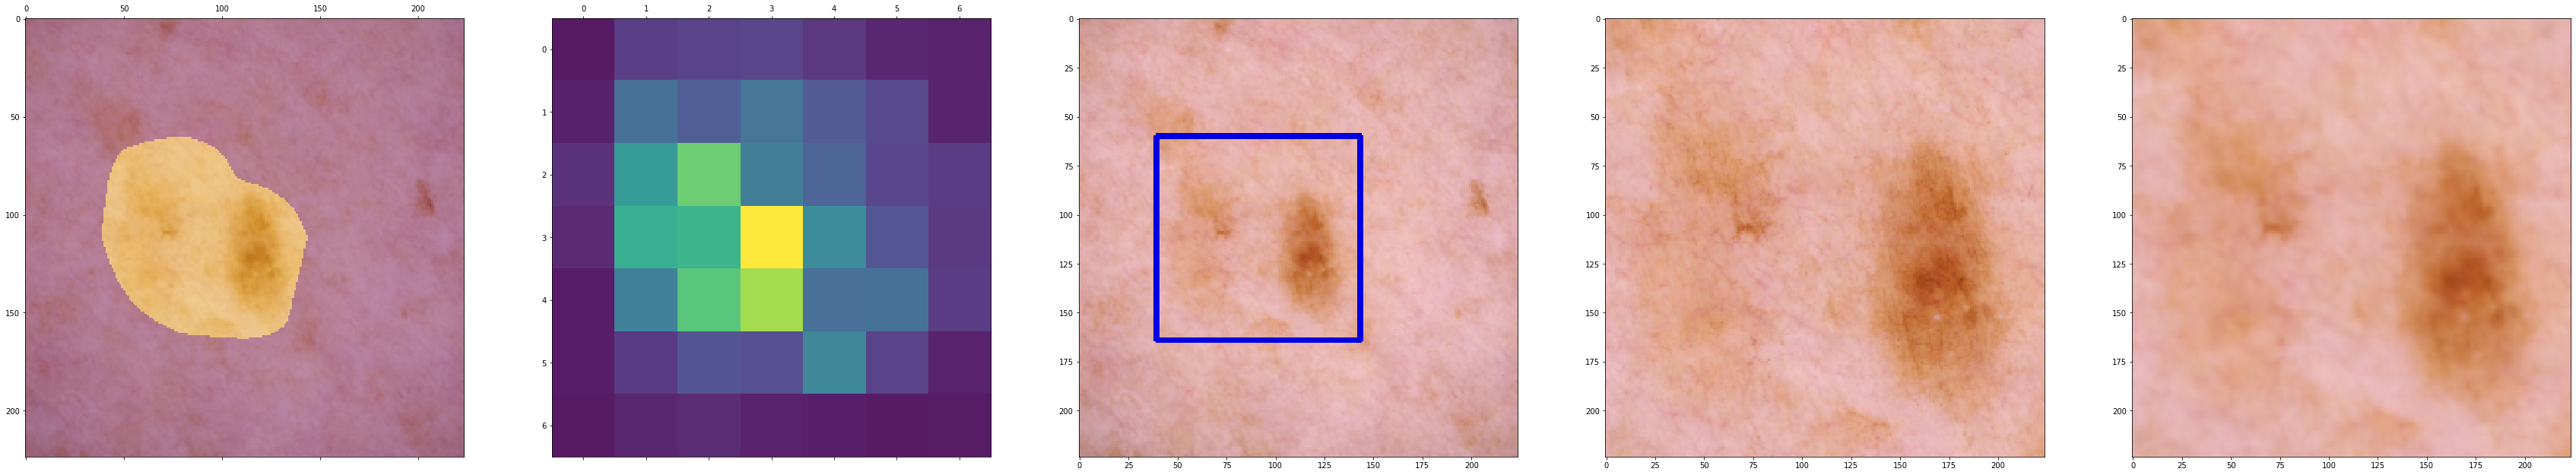

In [28]:
num_devs = 1.

idx = random.randint(0, len(test_data))
test_img = Image.fromarray(test_data[idx])
hw= float(test_img.size[0])

np_img = test_data[idx].copy()
orig_img = test_img.copy()

test_img = no_transform(test_img)
test_img = test_img.cuda()

chips = test_img.data.unfold(0, 3, 3).unfold(1, 32, 32).unfold(2, 32, 32)[0]
chips = chips.reshape(-1, 3, 32, 32)

output = model(chips.unsqueeze(0), _)

print(f"model output: {torch.sigmoid(output).item()}")

attn_map = model.attn_map[0]

upscaled = cv2.resize(attn_map.view(7, 7).detach().cpu().numpy(), (224, 224), interpolation=cv2.INTER_LINEAR)
binary = (upscaled > (upscaled.mean() + upscaled.std() * num_devs)).astype(np.uint8)

test = skimage.measure.label(binary)
props = skimage.measure.regionprops(binary)
prop = props[0]

sqr_bb = get_square_bbox(prop.bbox)
print(sqr_bb)
cv2.rectangle(np_img, (sqr_bb[0], sqr_bb[1]), (sqr_bb[2], sqr_bb[3]), (0, 0, 225), 2)
    
img_name = test_csv.iloc[idx]['image_name']
full_sz = Image.open(f'{full_sz_path}{img_name}.jpg')
full_hw = float(full_sz.size[0])

adj_bb = [pt * (full_hw / hw) for pt in sqr_bb]

cropped = transforms.functional.crop(
    full_sz, 
    adj_bb[1], 
    adj_bb[0], 
    adj_bb[2] - adj_bb[0], 
    adj_bb[3] - adj_bb[1]
)
cropped = transforms.functional.resize(cropped, 224, interpolation=5)
    
scaled_crop = transforms.functional.crop(
    orig_img, 
    sqr_bb[1], 
    sqr_bb[0], 
    sqr_bb[2] - sqr_bb[0], 
    sqr_bb[3] - sqr_bb[1], 
)
scaled_crop = transforms.functional.resize(scaled_crop, 224, interpolation=2)

print(f'mulitplier: {(full_hw / hw)}')

fig, axes = plt.subplots(1, 5, figsize=(60, 30))

axes[0].imshow(orig_img)
axes[1].matshow(model.attn_map[0].view(7, 7).detach().cpu().numpy(), alpha=0.9)
axes[0].matshow(binary.reshape(224, 224), alpha=0.3)
axes[2].imshow(np_img)
axes[3].imshow(cropped, interpolation='none')
axes[4].imshow(scaled_crop, interpolation='none')

In [157]:
hw = 224

def zoom_enhance(model_path, csv_path, data_path, full_sz_path, output_path, num_devs=1.5):
    
    no_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
    
    model = torch.load(model_path)
    model.eval()
    csv = pd.read_csv(csv_path)
    data = np.load(data_path)
    
    images = []
    for img, fname in tqdm(zip(data, csv['image_name'])):
        
        np_img = img.copy()
        img = Image.fromarray(img)

        img = no_transform(img)
        img = img.cuda()

        chips = img.data.unfold(0, 3, 3).unfold(1, 32, 32).unfold(2, 32, 32)[0]
        chips = chips.reshape(-1, 3, 32, 32)

        output = model(chips.unsqueeze(0), _)

        attn_map = model.attn_map[0]

        upscaled = cv2.resize(attn_map.view(7, 7).detach().cpu().numpy(), (224, 224), interpolation=cv2.INTER_LINEAR)
        binary = (upscaled > (upscaled.mean() + upscaled.std() * num_devs)).astype(np.uint8)

        props = skimage.measure.regionprops(binary)
        prop = props[0]
        sqr_bb = get_square_bbox(prop.bbox)
        
        full_sz = Image.open(f'{full_sz_path}{fname}.jpg')
        full_hw = float(full_sz.size[0])

        adj_bb = [pt * (full_hw / hw) for pt in sqr_bb]

        cropped = transforms.functional.crop(
            full_sz, 
            adj_bb[1], 
            adj_bb[0], 
            adj_bb[2] - adj_bb[0], 
            adj_bb[3] - adj_bb[1]
        )
        cropped = transforms.functional.resize(cropped, (224, 224), interpolation=5)
        cropped_arr = np.array(cropped)
        
        images.append(cropped_arr)
    
    output = np.stack(images, axis=0)
    np.save(output_path, output)
    

In [ ]:
zoom_enhance(
    'weights/chip_weights/model_fold1.pt', 
    'data/train.csv', 
    'data/train_224.npy',
    'data/fullsize/train/',
    'data/crop_data/cropped_fold1_train.npy'
)

zoom_enhance(
    'weights/chip_weights/model_fold1.pt', 
    'data/test.csv', 
    'data/test_224.npy',
    'data/fullsize/test/',
    'data/crop_data/cropped_fold1_test.npy'
)

zoom_enhance(
    'weights/chip_weights/model_fold2.pt', 
    'data/train.csv', 
    'data/train_224.npy',
    'data/fullsize/train/',
    'data/crop_data/cropped_fold2_train.npy'
)

zoom_enhance(
    'weights/chip_weights/model_fold2.pt', 
    'data/test.csv', 
    'data/test_224.npy',
    'data/fullsize/test/',
    'data/crop_data/cropped_fold2_test.npy'
)

zoom_enhance(
    'weights/chip_weights/model_fold3.pt', 
    'data/train.csv', 
    'data/train_224.npy',
    'data/fullsize/train/',
    'data/crop_data/cropped_fold3_train.npy'
)

zoom_enhance(
    'weights/chip_weights/model_fold3.pt', 
    'data/test.csv', 
    'data/test_224.npy',
    'data/fullsize/test/',
    'data/crop_data/cropped_fold3_test.npy'
)

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [102]:
def visualize_crop(model_path, csv_path, data_path, full_sz_path, num_devs=1.7):
    hw = 224

    model = torch.load(model_path)
    model.eval()
    
    data = np.load(data_path)
    csv = pd.read_csv(csv_path)

    rand_idx = np.random.choice(len(data), 5, replace=False)
    rand_imgs = data[rand_idx]
    rand_names = [csv['image_name'][i] for i in rand_idx]
    
    del data
    
    fig, axes = plt.subplots(2, 5, figsize=(50, 20))
    
    for i, (img, fname) in enumerate(zip(rand_imgs, rand_names)):
        
        np_img = img.copy()
        img = Image.fromarray(img)
        orig_img = img.copy()

        img = no_transform(img)
        img = img.cuda()

        chips = img.data.unfold(0, 3, 3).unfold(1, 32, 32).unfold(2, 32, 32)[0]
        chips = chips.reshape(-1, 3, 32, 32)

        output = model(chips.unsqueeze(0), _)

        attn_map = model.attn_map[0]

        upscaled = cv2.resize(attn_map.view(7, 7).detach().cpu().numpy(), (224, 224), interpolation=cv2.INTER_LINEAR)
        binary = (upscaled > (upscaled.mean() + upscaled.std() * num_devs)).astype(np.uint8)

        props = skimage.measure.regionprops(binary)
        prop = props[0]
        sqr_bb = get_square_bbox(prop.bbox)
        
        full_sz = Image.open(f'{full_sz_path}{fname}.jpg')
        full_hw = float(full_sz.size[0])

        adj_bb = [pt * (full_hw / hw) for pt in sqr_bb]

        cropped = transforms.functional.crop(
            full_sz, 
            adj_bb[1], 
            adj_bb[0], 
            adj_bb[2] - adj_bb[0], 
            adj_bb[3] - adj_bb[1]
        )
        cropped = transforms.functional.resize(cropped, (224, 224), interpolation=5)
        
        axes[0][i].imshow(orig_img)
        axes[1][i].imshow(cropped)


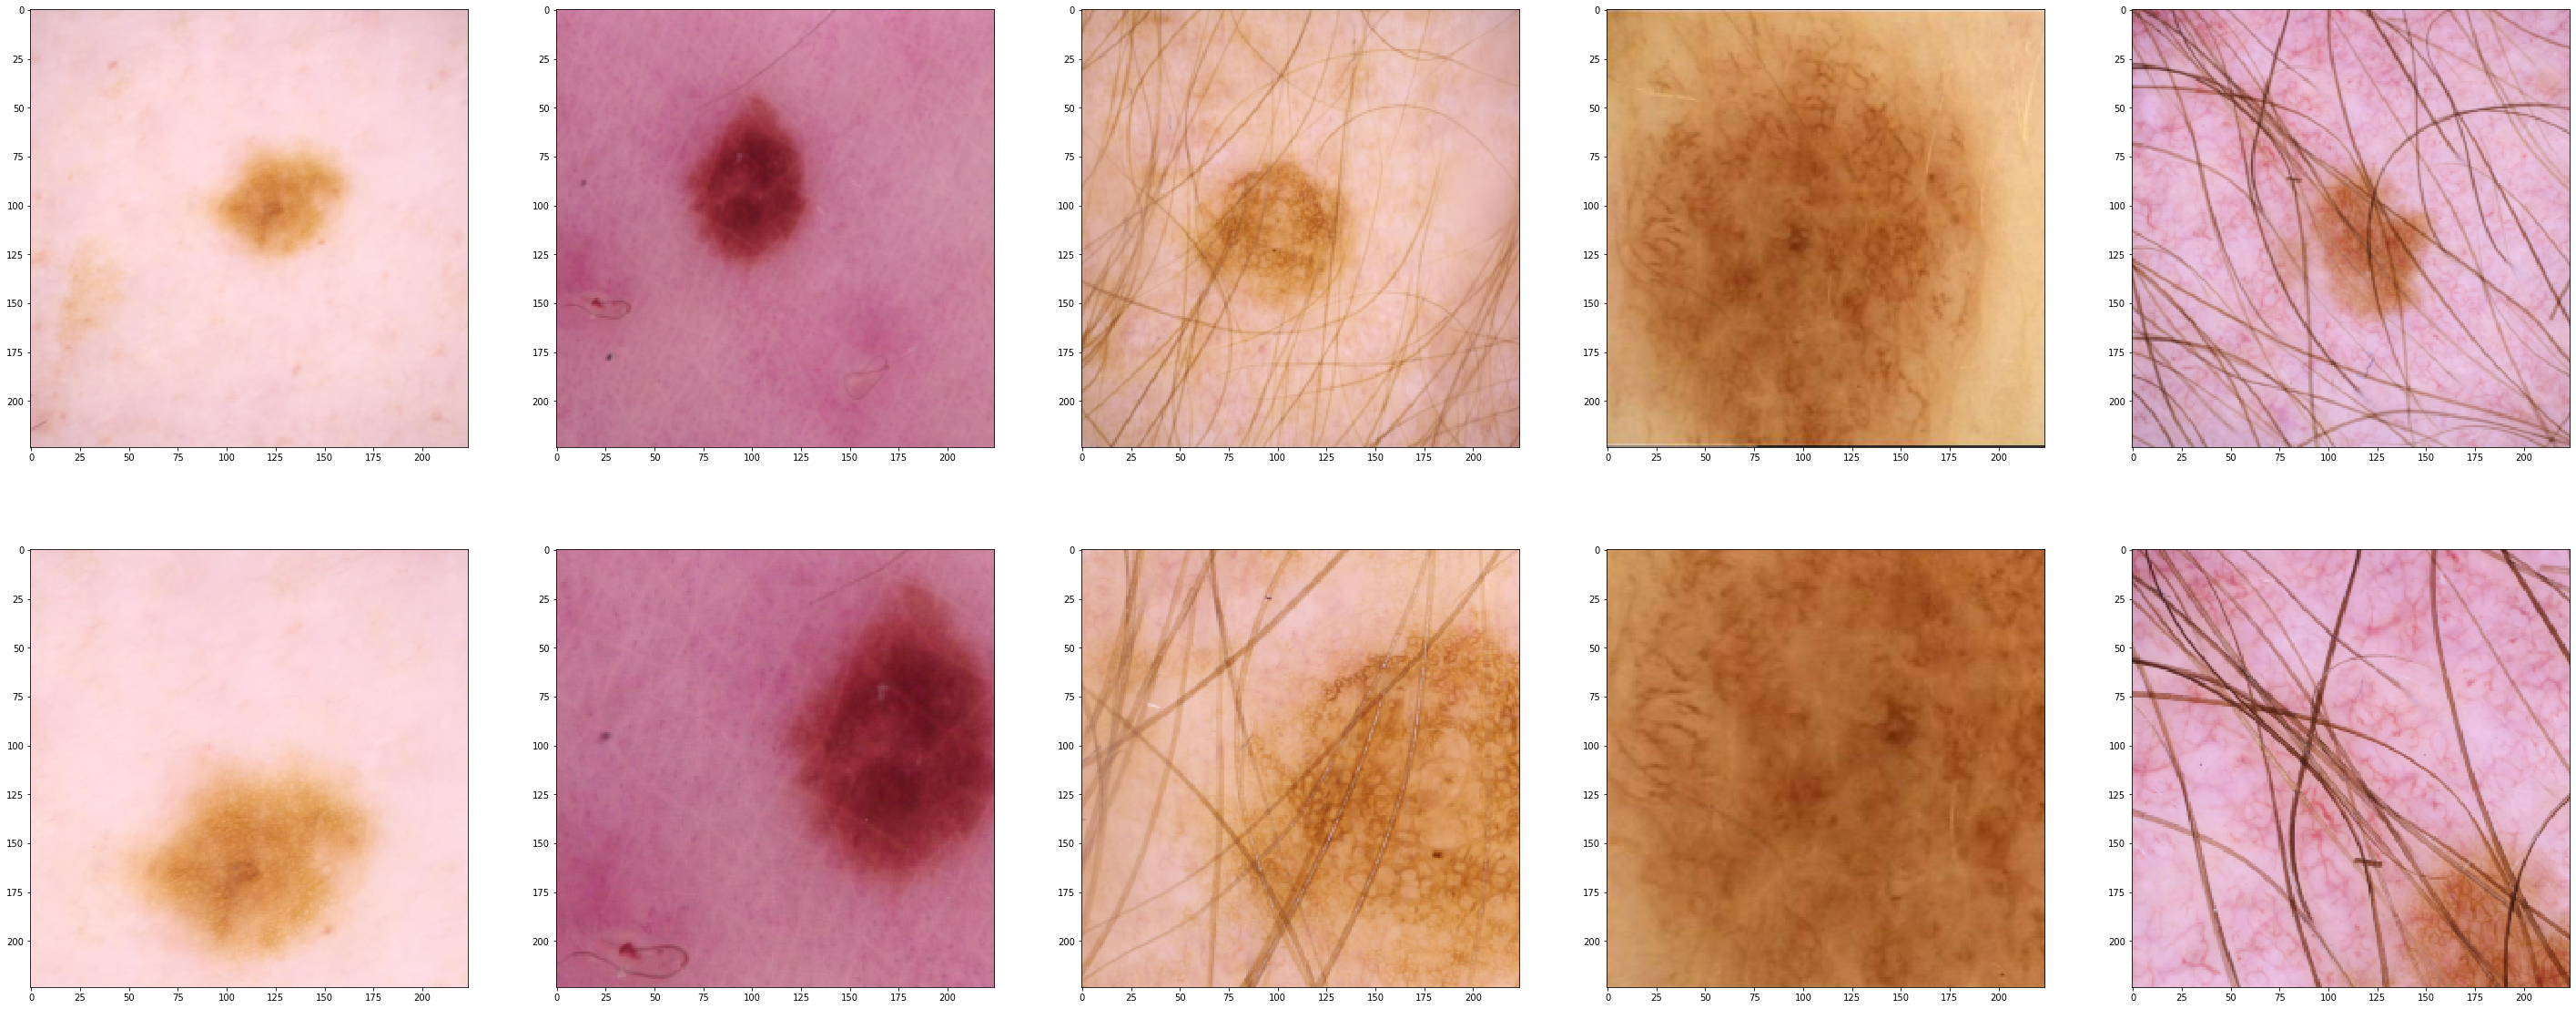

In [104]:
visualize_crop(
    'weights/chip_weights/model_fold1_epoch7.pt', 
    'data/test.csv', 
    'data/test_224.npy',
    'data/fullsize/test/'
)

took: 0.019997835159301758
took: 0.0010197162628173828


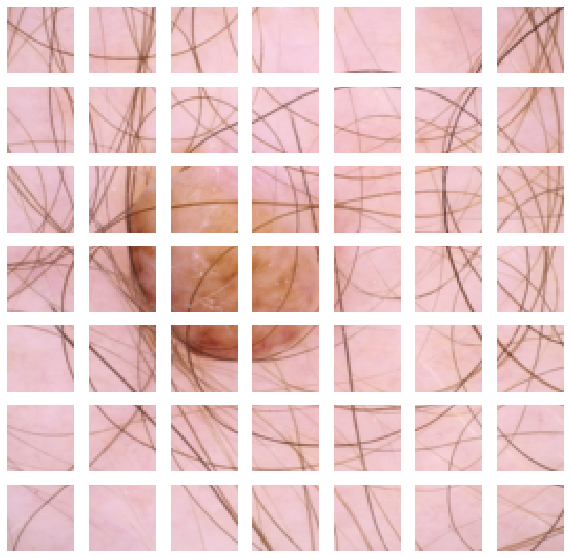

In [21]:
import time

img = test_data[1]
size = 32

fig, axes = plt.subplots(7, 7, figsize=(10, 10))

start = time.time()
for i in range(7):
    for j in range(7):
        start_x, start_y = size * i, size * j
        chip = img[start_x : start_x + size, start_y : start_y + size, :]
        axes[i][j].imshow(chip)
        axes[i][j].axis('off')
        
print(f"took: {time.time() - start}")

start = time.time()
img = torch.from_numpy(img).permute(2, 0, 1)
img = img.unfold(0, 3, 3).unfold(1, 32, 32).unfold(2, 32, 32)[0]
img = img.reshape(-1, 3, 32 ,32)
print(f"took: {time.time() - start}")

In [45]:
crop_data = np.load('data/crop_data/cropped_fold1_test.npy')[:300]
test_data = np.load('data/test_224.npy')[:300]

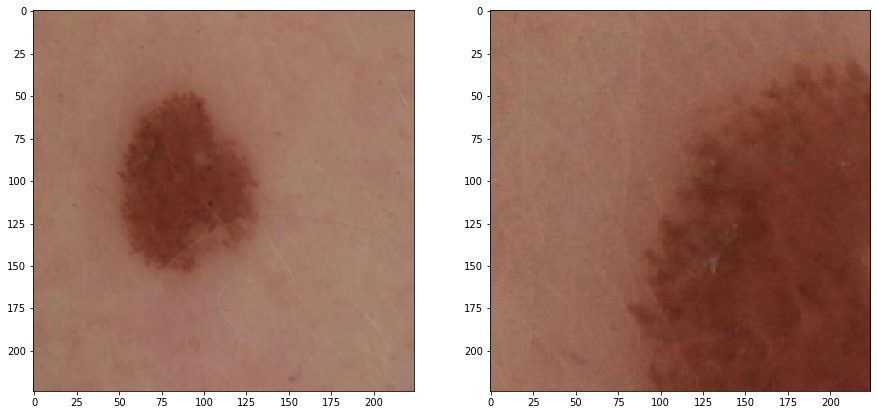

In [95]:
rand_idx = random.randint(0, 300)
fig, axes = plt.subplots(1, 2, figsize=(15, 30))
axes[0].imshow(Image.fromarray(test_data[rand_idx]))
axes[1].imshow(Image.fromarray(crop_data[rand_idx]))